In [13]:
import os
import shutil
import glob
import SimpleITK as sitk
import six
import radiomics
import getopt
import sys
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from radiomics import featureextractor, getTestCase
import pydicom
import pydicom_seg
import SimpleITK as sitk
import ast
import json
import pandas
import seaborn as sns
# importing the zipfile module
from zipfile import ZipFile
BASE_PATH = "/data4/hrehman/Clinical_Data/"

# BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
# INPUT_FOLDER = 'data4/Clinical Data/3-13-2023/'
INPUT_FOLDER = BASE_PATH + '3-13-2023/'
# INPUT_FOLDER_zipped = BASE_PATH_zipped
# patients_zipped = os.listdir(INPUT_FOLDER_zipped)
# patients_zipped.sort()
segmentaion_dict = {}

Comparison of brain test images from github with the data we have and see if everything is ok

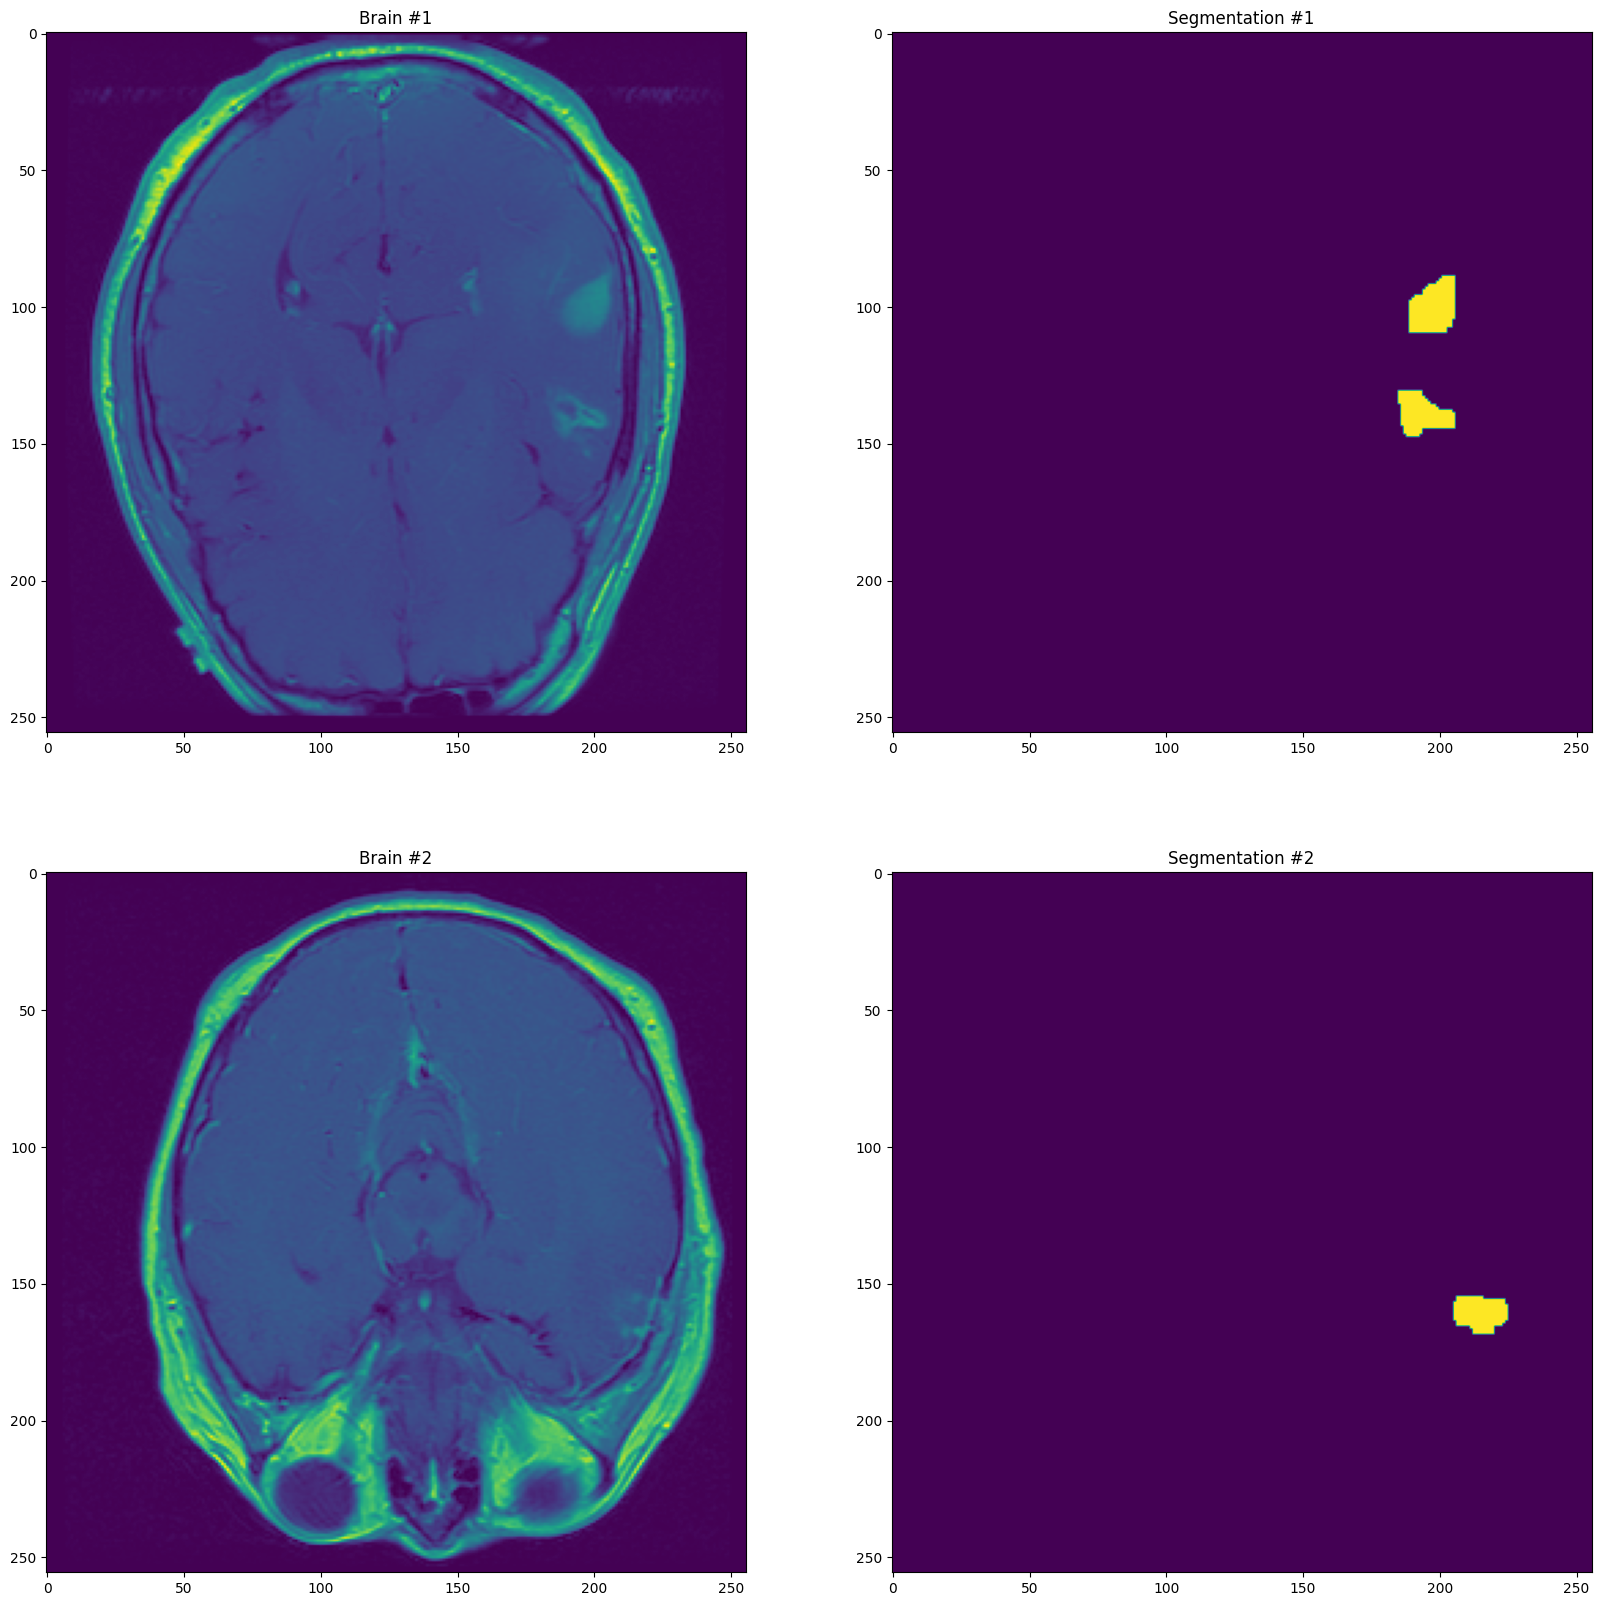

In [5]:
import os
import SimpleITK as sitk

from radiomics import getTestCase

imagepath_1, labelpath_1 = getTestCase('brain1')
imagepath_2, labelpath_2 = getTestCase('brain2')

image_1 = sitk.ReadImage(imagepath_1)
label_1 = sitk.ReadImage(labelpath_1)
image_2 = sitk.ReadImage(imagepath_2)
label_2 = sitk.ReadImage(labelpath_2)
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[12,:,:])
plt.title("Brain #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[12,:,:])        
plt.title("Segmentation #1")

# Second image
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(image_2)[8,:,:])        
plt.title("Brain #2")

plt.subplot(2,2,4)
plt.imshow(sitk.GetArrayFromImage(label_2)[8,:,:])        
plt.title("Segmentation #2")

plt.show()

Here we will unzip the data of all tghe patients to another folder and once the dicoms are extracted, we will convert to Nifti and delete the original one

In [14]:
def unzipping_segFiles():
    for patient in patients_zipped:
        zipped_folder = os.listdir(BASE_PATH_zipped + patient + "/SEG/")[0]
        with ZipFile(BASE_PATH_zipped + patient + "/SEG/" + zipped_folder, 'r') as zip:
            # printing all the contents of the zip file
            # extracting all the files
            print('Extracting all the files now...')
            zip.extractall(INPUT_FOLDER + patient + "/SEG/")
            print('Done!')
def unzipping_ctFiles():
    for patient in patients_zipped:
        zipped_folder = os.listdir(BASE_PATH_zipped + patient + "/CT/")[0]
        with ZipFile(BASE_PATH_zipped + patient + "/CT/" + zipped_folder, 'r') as zip:
            # printing all the contents of the zip file
            # extracting all the files
            print('Extracting all the files now...')
            zip.extractall(INPUT_FOLDER + patient + "/CT/")
            print('Done!')
#Uncommets these lines if you have to unzip the dicoms
# unzipping_segFiles()
# unzipping_ctFiles()

#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [15]:
len(patients)

137

In [69]:
# These are all those patients who have missing segmentations 
# patients = ["R01-020","R01-049","R01-052","R01-056","R01-075","R01-090","R01-098","R01-026","R01-044","R01-048","R01-078"]

In [71]:
def last_4chars(x):
    return(x[-1:])

def sort_dcm_files_CT(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
    path = INPUT_FOLDER + patient + '/CT/'
    list_of_files = os.listdir(path)
    # for specific cases like the patinets in the above cell you can see they have different file formate, in order to fix this we have to perform sorting on the second part of the filename
    # this line is for sorting on first part of the -
    list_of_files = sorted(list_of_files, key=lambda x: int(x.split("-")[0]))
    # this line is for sorting on second part of the - for the patinets that are above mentioned
    # list_of_files = sorted(list_of_files, key=lambda x: int(str(x.split("-")[1]).split(".")[0]))
    return list_of_files
def get_SEG(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
    path = INPUT_FOLDER + patient + '/SEG/'
    file = os.listdir(path)
    return file

def get_reference_segmnetation(ds):
    reference_CT = ds[0x0008, 0x1115][0][0x0008, 0x114a]
    return reference_CT

In the follwing chuck we are reading each dicom file , find the corresponding segmentation of each dicom , and then create a json format file which saves the key as CT scan number and the value as the position of segmentation from all the stacked slices of a lung.
it took 7 minutes for the conversion

In [72]:
#iterating the patinets
for patient in patients:
    print(patient)
    segmentaion_dict = {}
    seg_ids = []
    #get a patient segmentation
    file = os.listdir(INPUT_FOLDER + patient + '/SEG')
    path = INPUT_FOLDER + patient + '/SEG/'
    # file = os.listdir(path)
    # print(patient)

    #Read the segmentation and get the reference CT of it
    SEG = dcmread(os.path.join(path,file[0]))
    segmentations = get_reference_segmnetation(SEG)
    #populate the dictionary with the values of segmentation as 0,1,2 ....
    for i,seg in enumerate(segmentations):
        seg_ids.append(str(seg[0x0008, 0x1155].value))
        segmentaion_dict[i] = ''

    #read files in sorted form according to the file system
    files = sort_dcm_files_CT(patient=patient)
    folder = os.listdir(INPUT_FOLDER + patient + '/CT')
    path = INPUT_FOLDER + patient + '/CT/'
    for file in files:
        CT = dcmread(os.path.join(path,file))
        # print(CT[0x0008, 0x0018].value)
        #read each file and find the slice number according to the SEG
        if str(CT[0x0008, 0x0018].value) in seg_ids:
            i = [i for i, j in enumerate(seg_ids) if j == str(CT[0x0008, 0x0018].value)]
            # for all the patinets #
            # segmentaion_dict[i[0]] = int(file.split('-')[0])-1
            # for some patinets as aboved mentioned
            # print("found")
            # print(str(file.split("-")[1]).split(".")[0])
            # print(i)
            segmentaion_dict[i[0]] = int(str(file.split("-")[1]).split(".")[0])-1
    #Write the information in a configuration file of each patient.
    with open( BASE_PATH + "Nifti/config/" + patient + ".txt", 'w') as f: 
        # for key, value in segmentaion_dict.items(): 
        #     f.write('%s:%s\n' % (key, value))
        json.dump(segmentaion_dict,f)

R01-014


convert dicom files to Nifti first for CT scans

In [78]:
# config_patinets = ["R01-020.txt","R01-049.txt","R01-052.txt","R01-056.txt","R01-075.txt","R01-090.txt","R01-098.txt"]
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [50]:
def convertCTFiles():
    count = 0
    for patient in patients:
        if str(patient+'.txt') in config_patinets:
            print(patient)
            path = BASE_PATH + "Nifti/" + patient + '/CT/'
            # folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
            if os.path.exists(path=path) == False:
                os.makedirs(path)
            # dicom2nifti.convert_directory(INPUT_FOLDER + patient + '/CT' + folder[0],path,sorter=last_4chars)
            files = sort_dcm_files_CT(patient=patient)
            dicom_list = [pydicom.read_file(os.path.join(INPUT_FOLDER + patient + '/CT/', f)) for f in files]
            dicom2nifti.convert_dicom.dicom_array_to_nifti(dicom_list,os.path.join(path, 'output.nii'),reorient_nifti=False)
            # dicom2nifti.dicom_series_to_nifti(dicom_list,os.path.join(path, 'output.nii.gz'),reorient_nifti=False)

convert dicom files to Nifti of Segmentaion

In [51]:
def convertSEGFiles():
    for patient in patients:
        if str(patient+'.txt') in config_patinets:
            print(patient)
            path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
            folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
            if os.path.exists(path=path) == False:
                os.makedirs(path)
            file = os.listdir(INPUT_FOLDER + patient + '/SEG/')
            dcm = pydicom.dcmread(INPUT_FOLDER + patient + '/SEG/'+file[0])
            reader = pydicom_seg.SegmentReader()
            result = reader.read(dcm)
            # print(result.available_segments)
            for segment_number in result.available_segments:
                image_data = result.segment_data(segment_number)  # directly available
                image = result.segment_image(segment_number)  # lazy construction
                sitk.WriteImage(image, str(path) + str(segment_number) + ".nii")

In [54]:
#It took 11 minutes to run the whole thing
convertCTFiles()

R01-020
R01-049
R01-052
R01-056
R01-075
R01-090
R01-098
R01-026
R01-044
R01-048
R01-078


In [53]:
convertSEGFiles()

R01-020
R01-049
R01-052
R01-056
R01-075
R01-090
R01-098
R01-026
R01-044
R01-048
R01-078


In [17]:
#Delete all the unzipped dicom files since they are occupying the space for not reason
# os.remove(r"/data4/hrehman/Clinical Data/3-13-2023")
import shutil
shutil.rmtree("/data4/hrehman/Clinical Data/3-13-2023/")

Here im just checking if the dicom files also have same issues with the segmentation

In [55]:
# reading the data from the file
with open(BASE_PATH + 'Nifti/config/R01-001.txt',"r") as f:
   config =  json.load(f)
CT = sitk.ReadImage( BASE_PATH +"/Nifti/R01-001/CT/output.nii")
CT = sitk.GetArrayFromImage(CT)
SEG = sitk.ReadImage(BASE_PATH + "/Nifti/R01-001/SEG/1.nii")
SEG = sitk.GetArrayFromImage(SEG)
config.get("0") #this says that the first Segmentaion has original CT on 5
sampleCT = CT[config.get("12"),:,:]
sampleSeg = SEG[12,:,:]


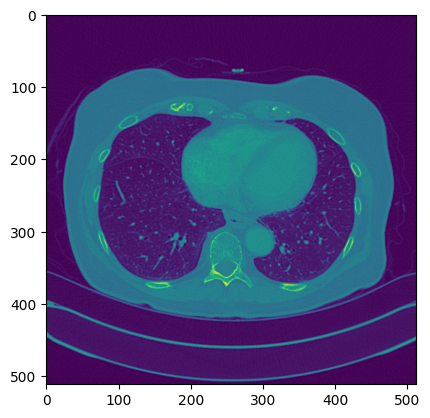

In [56]:
plt.imshow(sampleCT)

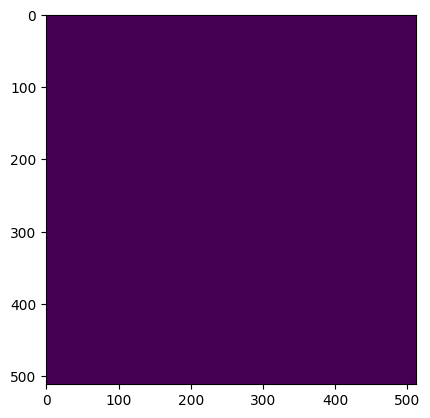

In [57]:
for i in range(0,50):
    plt.imshow(SEG[i,:,:])

We encountered a situation here where number of patines had nothing in the segmentation and had blank images , now the idea I have is to delete/ignore those slices which have all zeros and only give the ones with segmented portion

In [59]:

def findStart(SEG):
    start = True
    count = len(SEG)
    startval = 0
    i = 0
    #Running Array into the forward direction to find start of segmentation set
    for img in SEG:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and start==True:
                start = False
                startval = i
                break
        i+=1
    return startval
def findEnd(SEG):
    end = True
    #Running Array into the backwards direction to find end of segmentation set
    i = len(SEG) -1
    count = 0
    endval = 0
    # SEG_rev = SEG[:, :, ::-1]
    SEG_rev  =np.flip(SEG, axis=None)
    # print(SEG_rev)
    for img in SEG_rev:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and end==True:
                end = False
                endval = i
                break
        i-=1
    return endval

In [64]:
#detele the segmentation with all values as zero
# reading the data from the file

for patient in patients:
    if str(patient+'.txt') in config_patinets:
        # print(patient)
        with open(BASE_PATH + 'Nifti/config/'+patient+'.txt',"r") as f:
            config =  json.load(f)
            # print(len(config))
        path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
        Segmentations = sitk.ReadImage(path + "1.nii")
        
        SEG = sitk.GetArrayFromImage(Segmentations)
        new_pixel_array = []
        
        #find start and end of the segmentation slices
        (start) = findStart(SEG)
        (end) = findEnd(SEG)
        ##Editing the configuration files
        i = 0
        count = len(SEG)
        for img in SEG:
            if start <= i and end >= i:
                new_pixel_array.append(img)
            else:
                config.pop(str(i))
            i+=1
        B = {str(j): v for j, v in enumerate(config.values())}
        # print(B)
        path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
        # if this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
        img = sitk.GetImageFromArray(new_pixel_array)
        with open(BASE_PATH + 'Nifti/config/'+patient+'.txt','w') as f:
            json.dump(B,f)
        sitk.WriteImage(img, str(path) + "clean.nii")


delete the slices without segmentation (usually takes 2 min)

In [81]:
import nibabel as nib
import numpy as np
count = 0 
for patient in patients:
    count+=1
    if str(patient+'.txt') in config_patinets:
        path = BASE_PATH + "Nifti/" + patient + '/CT/'
        # Load the original NIfTI file
        nii_file = nib.load(path + "output.nii")

        # Get the image data as a Numpy array
        image_data = nii_file.get_fdata()

        # reading the data from the file
        with open(BASE_PATH + 'Nifti/config/'+patient+'.txt',"r") as f:
            config =  json.load(f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        # Define the dictionary that specifies the slice order
        slice_order = config
        
        # Create a new Numpy array to hold the reordered slices
        new_image_data = np.zeros((512,512,len(config)),dtype="int16")

        # Loop through the dictionary and copy each slice to its new position
        for new_idx, old_idx in slice_order.items():
            print()
            new_idx = int(new_idx)
            old_idx = int(old_idx)
            new_image_data[:, :, new_idx] = image_data[:, :, old_idx]

        # Create a new NIfTI file with the reordered slices
        new_nii_file = nib.Nifti1Image(new_image_data, nii_file.affine, header=nii_file.header)

        # Save the new NIfTI file
        nib.save(new_nii_file, path + "output_clean.nii")
print(count , "Patients CT data was cleaned with relavent segmentations")

extraction of radiomics features from one sample for testing purpose

In [43]:
# image  = BASE_PATH + "Nifti/R01-136/CT/output.nii"
# mask = BASE_PATH + "Nifti/R01-136/SEG/1.nii"
# mask = sitk.ReadImage(mask)
# image = sitk.ReadImage(image)
# image = sitk.Cast(image,sitk.sitkInt16)
# mask = sitk.Cast(mask,sitk.sitkInt16)
# plt.figure(figsize=(20,20))
# # First image
# plt.subplot(2,2,1)
# plt.imshow(sitk.GetArrayFromImage(image)[9,:,:])
# plt.title("Lungs #1")
# plt.subplot(2,2,2)
# plt.imshow(sitk.GetArrayFromImage(mask)[9,:,:])        
# plt.title("Segmentation #1")
# # save physical info
# spacing = image.GetSpacing()
# direction = image.GetDirection()
# origin = image.GetOrigin()
# # set physical info
# mask.SetSpacing(spacing)
# # image.SetSpacing([1.0]*3)
# mask.SetOrigin(origin)
# # image.SetOrigin([0.0]*3)
# mask.SetDirection(direction)
# # image.SetDirection([1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0])
# # restore physical
# # x.SetSpacing(spacing)
# # x.SetDirection(direction)
# extractor = featureextractor.RadiomicsFeatureExtractor(params)
# result = extractor.execute(image,mask)
# print(result.values())
# print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
# print('')
# print('Calculated features')
# for key, value in six.iteritems(result):
#     print('\t', key, ':', value)